In [ ]:
#@title 1) 安装依赖（PyBullet 3.2.7 + NumPy 2.x 兼容）
!pip install --upgrade pip setuptools wheel
!pip install pybullet==3.2.7 ultralytics==8.3.72 opencv-python-headless==4.10.0.84 \
             numpy==2.1.1 matplotlib==3.9.2 tqdm==4.66.5 pyyaml==6.0.2


  Using cached ultralytics-8.3.72-py3-none-any.whl.metadata (35 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached ultralytics-8.3.72-py3-none-any.whl (914 kB)
Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached ultralytics_thop-2.0.18-py3-none-any.whl (28 kB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uni

In [ ]:
import os, random, time, yaml, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pybullet as p
import pybullet_data
from ultralytics import YOLO
import torch
print('Torch CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch CUDA available: True
CUDA device: Tesla T4


In [ ]:
#@title 2) 全局参数（按 Claude 建议）
ROOM_XY = 6.0
ROOM_H  = 3.0
W, H = 640, 480
DATA_ROOT = '/content/mc_dataset'
CLASSES = ['yellow_duck', 'r2d2_robot', 'teddy_bear']
OUT_MP4 = '/content/multi_cam_sim.mp4'
FPS = 24
SIM_FRAMES = 300
# FOV_DEG = 110  # Claude 推荐
# 训练阶段
min_pixels=20   # segmentation 过滤阈值稍高
FOV_DEG=135     # 视野再放宽一点

In [ ]:
#@title 3) 初始化 PyBullet（含 EGL 探测）
def init_bullet_with_optional_egl():
    cid = p.connect(p.DIRECT)
    use_gpu = False
    try:
        egl = p.loadPlugin('eglRendererPlugin')
        print('EGL plugin loaded:', egl)
        use_gpu = True
    except Exception as e:
        print('EGL not available, using TinyRenderer. Reason:', e)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0,0,-9.81)
    return cid, use_gpu

def start_bullet():
    if p.isConnected():
        p.disconnect()
    cid, use_gpu = init_bullet_with_optional_egl()
    p.resetSimulation()
    p.setGravity(0,0,-9.81)
    plane = p.loadURDF('plane.urdf')
    wall_thick = 0.05
    half = ROOM_XY/2
    col_box = p.createCollisionShape(p.GEOM_BOX, halfExtents=[half, wall_thick, ROOM_H/2])
    vis_grey = p.createVisualShape(p.GEOM_BOX, halfExtents=[half, wall_thick, ROOM_H/2], rgbaColor=[0.8,0.8,0.8,1])
    p.createMultiBody(0, col_box, vis_grey, [0,  half, ROOM_H/2])
    p.createMultiBody(0, col_box, vis_grey, [0, -half, ROOM_H/2])
    col_box2 = p.createCollisionShape(p.GEOM_BOX, halfExtents=[wall_thick, half, ROOM_H/2])
    vis_grey2 = p.createVisualShape(p.GEOM_BOX, halfExtents=[wall_thick, half, ROOM_H/2], rgbaColor=[0.8,0.8,0.8,1])
    p.createMultiBody(0, col_box2, vis_grey2, [ half, 0, ROOM_H/2])
    p.createMultiBody(0, col_box2, vis_grey2, [-half, 0, ROOM_H/2])
    return cid, use_gpu

_cid, _use_gpu = init_bullet_with_optional_egl()
p.disconnect()

EGL plugin loaded: -1


In [ ]:
# 4) 工具（玩具/渲染/反投影/可见性）
def spawn_objects():
    objs=[]
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    duck = p.loadURDF('duck_vhacd.urdf', basePosition=[-1.0,-1.0,0.05], globalScaling=10.)
    objs.append((duck,'yellow_duck'))
    r2d2 = p.loadURDF('r2d2.urdf', basePosition=[ 1.0,-1.0,0.05], globalScaling=1.0)
    objs.append((r2d2,'r2d2_robot'))
    teddy= p.loadURDF('teddy_vhacd.urdf', basePosition=[ 0.0, 1.0,0.05], globalScaling=8.)
    objs.append((teddy,'teddy_bear'))
    return objs

def look_at(from_xyz, to_xyz):
    up = [0, 1, 0] if abs(from_xyz[2]-to_xyz[2]) < 0.5 else [0,0,1]
    return p.computeViewMatrix(from_xyz, to_xyz, up)

def camera_specs(width, height, fov_deg=130, near=0.01, far=20.0):
    return p.computeProjectionMatrixFOV(fov=fov_deg, aspect=width/height, nearVal=near, farVal=far)

def render_camera(cam_pose, target, width, height, use_gpu=False):
    view = look_at(cam_pose, target)
    proj = camera_specs(width, height, fov_deg=FOV_DEG)
    renderer = p.ER_BULLET_HARDWARE_OPENGL if use_gpu else p.ER_TINY_RENDERER
    flags = p.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX
    img = p.getCameraImage(width, height, view, proj, shadow=0, renderer=renderer, flags=flags)
    rgb   = np.reshape(img[2], (height, width, 4))[:,:,:3].astype(np.uint8)
    depth = np.reshape(img[3], (height, width))
    seg   = np.reshape(img[4], (height, width))
    return rgb, depth, seg, view, proj

def corner_cameras(height=1.2, margin=1.0):
    h = height
    half = ROOM_XY/2 - margin
    return [
        np.array([-half, -half, h]),
        np.array([ half, -half, h]),
        np.array([ half,  half, h]),
        np.array([-half,  half, h]),
    ]

def unproject_to_world(pixel_xy, view, proj, width, height):
    V = np.array(view).reshape(4,4).T
    P = np.array(proj).reshape(4,4).T
    invVP = np.linalg.inv(P @ V)
    x_ndc = (pixel_xy[0]/width)*2 - 1
    y_ndc = 1 - (pixel_xy[1]/height)*2
    p_near = np.array([x_ndc, y_ndc, -1, 1])
    p_far  = np.array([x_ndc, y_ndc,  1, 1])
    w_near = invVP @ p_near; w_near = w_near[:3]/w_near[3]
    w_far  = invVP @ p_far;  w_far  = w_far[:3]/w_far[3]
    ray_o = w_near; ray_d = w_far - w_near
    if abs(ray_d[2]) < 1e-6: return None
    t = -ray_o[2]/ray_d[2]
    if t < 0: return None
    hit = ray_o + t*ray_d
    return float(hit[0]), float(hit[1])

def yolo_bboxes_from_seg(seg, body_ids, w, h, min_pixels=min_pixels):
    obj_uid = (seg & ((1 << 24) - 1)).astype(np.int32)
    bboxes = {}
    for bid in body_ids:
        ys, xs = np.where(obj_uid == bid)
        if ys.size < min_pixels:
            continue
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        cx = (x0 + x1) / 2 / w
        cy = (y0 + y1) / 2 / h
        bw = (x1 - x0) / w
        bh = (y1 - y0) / h
        if bw >= 0.98 or bh >= 0.98:
            continue
        bboxes[bid] = (cx, cy, bw, bh)
    return bboxes

def visibility_report_once(objs, cams, target, w, h, use_gpu):
    rep = []
    for ci, cam in enumerate(cams):
        rgb, depth, seg, view, proj = render_camera(cam, target, w, h, use_gpu)
        obj_uid = (seg & ((1 << 24) - 1)).astype(np.int32)
        vis_cnt = 0
        for bid,_ in objs:
            if np.any(obj_uid == bid):
                vis_cnt += 1
        rep.append((ci, vis_cnt))
    return rep

In [ ]:
#@title 5) 生成合成数据集（seg提标注）
def ensure_dirs():
    for split in ['train','val']:
        os.makedirs(f'{DATA_ROOT}/images/{split}', exist_ok=True)
        os.makedirs(f'{DATA_ROOT}/labels/{split}', exist_ok=True)
ensure_dirs()

def write_data_yaml():
    data = {'path': DATA_ROOT,'train': 'images/train','val': 'images/val','names': {i:n for i,n in enumerate(CLASSES)}}
    with open(f'{DATA_ROOT}/data.yaml','w') as f: yaml.dump(data, f)
write_data_yaml()

def randomize_object_states(objs):
    half = ROOM_XY/2 - 1.0
    for bid,_ in objs:
        x = np.random.uniform(-half, half)
        y = np.random.uniform(-half, half)
        p.resetBasePositionAndOrientation(bid, [x,y,0.2], p.getQuaternionFromEuler([0,0,0]))

In [ ]:
import shutil, os

DATA_ROOT = '/content/mc_dataset'
if os.path.exists(DATA_ROOT):
    shutil.rmtree(DATA_ROOT)
os.makedirs(f'{DATA_ROOT}/images/train', exist_ok=True)
os.makedirs(f'{DATA_ROOT}/images/val', exist_ok=True)
os.makedirs(f'{DATA_ROOT}/labels/train', exist_ok=True)
os.makedirs(f'{DATA_ROOT}/labels/val', exist_ok=True)
print("✅ 数据已清空并重建空目录。")

In [ ]:
def generate_split(split='train', n_scenes=240, cams_per_scene=4, img_size=(640,480)):
    w,h = img_size
    cid, use_gpu = start_bullet()
    objs = spawn_objects()
    cams = corner_cameras(height=1.2, margin=1.0)
    target = [0,0,0.2]

    for i in trange(n_scenes, desc=f'gen {split}'):
        randomize_object_states(objs)
        chosen = random.sample(range(4), k=cams_per_scene)
        for k,ci in enumerate(chosen):
            rgb, depth, seg, view, proj = render_camera(cams[ci], target, w, h, use_gpu)
            fname = f'{split}_{i:04d}_{k}_{ci}.jpg'
            cv2.imwrite(f'{DATA_ROOT}/images/{split}/{fname}', cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

            body_ids = [bid for (bid, _) in objs]
            bid2bbox = yolo_bboxes_from_seg(seg, body_ids, w, h, min_pixels=10)

            lines = []
            for (bid, name) in objs:
                if bid in bid2bbox:
                    cls = CLASSES.index(name)
                    cx,cy,bw,bh = bid2bbox[bid]
                    lines.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")
            with open(f"{DATA_ROOT}/labels/{split}/{fname.replace('.jpg','.txt')}", 'w') as f:
                f.writelines(lines)
    p.disconnect()

generate_split('train', n_scenes=240, cams_per_scene=4, img_size=(W,H))
generate_split('val',   n_scenes=60,  cams_per_scene=4, img_size=(W,H))
print('Dataset ready at', DATA_ROOT)

EGL plugin loaded: -1


gen train: 100%|██████████| 240/240 [01:33<00:00,  2.56it/s]


EGL plugin loaded: -1


gen val: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]

Dataset ready at /content/mc_dataset


[train] images: 960 labels: 960
  first-200 missing label files: 0
[train] label files: 960
  empty files: 0 (0.0%)
  >0.9 width/height entries: 0
  <0.01 width/height entries: 9
[val] images: 240 labels: 240
  first-200 missing label files: 0
[val] label files: 240
  empty files: 0 (0.0%)
  >0.9 width/height entries: 0
  <0.01 width/height entries: 6


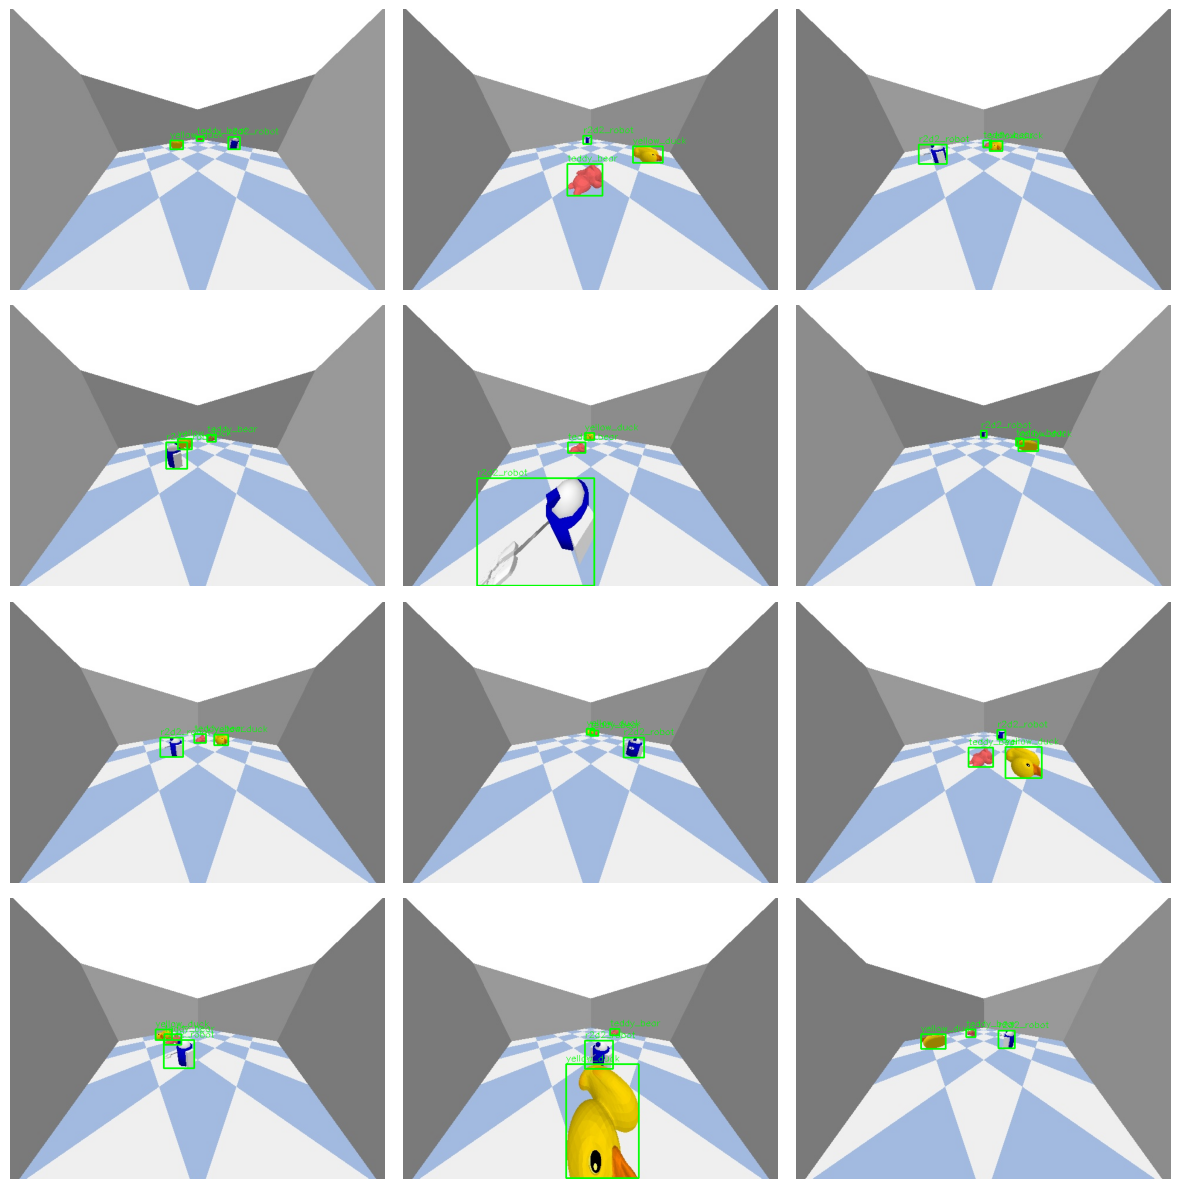

Occurrence stats: {'yellow_duck': 960, 'r2d2_robot': 960, 'teddy_bear': 954}


In [ ]:
#@title 6) 健康检查 + 样例可视化 + 出现次数统计
import glob
def check_counts(split='train'):
    imgs = sorted(glob.glob(f'{DATA_ROOT}/images/{split}/*.jpg'))
    lbls = sorted(glob.glob(f'{DATA_ROOT}/labels/{split}/*.txt'))
    print(f'[{split}] images:', len(imgs), 'labels:', len(lbls))
    miss = 0
    for ip in imgs[:200]:
        name = os.path.basename(ip).replace('.jpg','.txt')
        if not os.path.exists(f'{DATA_ROOT}/labels/{split}/{name}'):
            miss += 1
    print(f'  first-200 missing label files: {miss}')

def analyze_labels(split='train'):
    lbl_dir = f'{DATA_ROOT}/labels/{split}'
    files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]
    total = len(files)
    empty = 0; big=0; small=0
    for f in files:
        path = os.path.join(lbl_dir, f)
        with open(path,'r') as fh:
            lines = [l.strip() for l in fh if l.strip()]
        if len(lines)==0:
            empty += 1; continue
        for line in lines:
            cid,cx,cy,bw,bh = line.split()
            bw, bh = float(bw), float(bh)
            if bw>0.9 or bh>0.9: big += 1
            if bw<0.01 or bh<0.01: small += 1
    print(f'[{split}] label files: {total}')
    print(f'  empty files: {empty} ({(empty/max(total,1)):.1%})')
    print(f'  >0.9 width/height entries: {big}')
    print(f'  <0.01 width/height entries: {small}')

def visualize_random(split='train', n=6):
    imgs = sorted(glob.glob(f'{DATA_ROOT}/images/{split}/*.jpg'))
    if not imgs:
        print('no images'); return
    picks = random.sample(imgs, min(n, len(imgs)))
    cols = 3
    rows = int(np.ceil(len(picks)/cols))
    plt.figure(figsize=(4*cols, 3*rows))
    for i, ip in enumerate(picks):
        img = cv2.cvtColor(cv2.imread(ip), cv2.COLOR_BGR2RGB)
        lbl = ip.replace('/images/','/labels/').replace('.jpg','.txt')
        if os.path.exists(lbl):
            with open(lbl,'r') as f:
                lines = [l.strip() for l in f if l.strip()]
            for line in lines:
                cid,cx,cy,bw,bh = line.split(); cid=int(cid)
                cx,cy,bw,bh = map(float,(cx,cy,bw,bh))
                x1 = int((cx-bw/2)*W); y1 = int((cy-bh/2)*H)
                x2 = int((cx+bw/2)*W); y2 = int((cy+bh/2)*H)
                cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
                cv2.putText(img, CLASSES[cid], (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),1)
        plt.subplot(rows, cols, i+1); plt.imshow(img); plt.axis('off')
    plt.tight_layout(); plt.show()

def count_object_occurrences(split='train'):
    lbl_dir = f'{DATA_ROOT}/labels/{split}'
    files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]
    counts = {name: 0 for name in CLASSES}
    for f in files:
        with open(os.path.join(lbl_dir,f),'r') as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts)<5: continue
                cid = int(parts[0])
                if 0 <= cid < len(CLASSES):
                    counts[CLASSES[cid]] += 1
    print('Occurrence stats:', counts)
    return counts

check_counts('train'); analyze_labels('train')
check_counts('val');   analyze_labels('val')
visualize_random('train', n=12)
_ = count_object_occurrences('train')

In [ ]:
#@title 7) 训练 YOLOv8n（GPU 优先）
data_yaml = f'{DATA_ROOT}/data.yaml'
device_arg = 0 if torch.cuda.is_available() else 'cpu'
model = YOLO('yolov8n.pt')
results = model.train(data=data_yaml, epochs=5, imgsz=W, batch=16, device=device_arg)
print('Training done. Check runs/detect/train*/weights/best.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 84.2MB/s]


New https://pypi.org/project/ultralytics/8.3.225 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.72 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/mc_dataset/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅


train: Scanning /content/mc_dataset/labels/train... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<00:00, 1652.28it/s]

train: New cache created: /content/mc_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/mc_dataset/labels/val... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 555.53it/s]

val: New cache created: /content/mc_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.24G      1.362      2.488     0.9831         86        640: 100%|██████████| 60/60 [00:12<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]

                   all        240        718    0.00799      0.785      0.531      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.18G      1.037      1.152     0.9158         75        640: 100%|██████████| 60/60 [00:08<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]

                   all        240        718      0.934      0.917      0.946      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.25G     0.9519     0.9764     0.8852         64        640: 100%|██████████| 60/60 [00:08<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]

                   all        240        718      0.971      0.948      0.973      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.27G     0.8679     0.8417     0.8626         88        640: 100%|██████████| 60/60 [00:08<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]

                   all        240        718      0.984      0.953      0.975      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.27G     0.8133     0.7642     0.8599         80        640: 100%|██████████| 60/60 [00:08<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.45it/s]

                   all        240        718      0.977      0.957      0.976      0.758



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.72 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.20it/s]


                   all        240        718       0.98      0.958      0.975      0.759
           yellow_duck        240        240      0.986       0.95      0.985      0.824
            r2d2_robot        240        240      0.971      0.986      0.992      0.712
            teddy_bear        238        238      0.982      0.937      0.948       0.74
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train
Training done. Check runs/detect/train*/weights/best.pt


In [ ]:
results.names

{0: 'red_cube', 1: 'green_cylinder', 2: 'blue_sphere'}

In [ ]:
#@title 8) 一致性测试 + 每摄像机可见物体数报告
def test_projection_consistency(trials=30, w=W, h=H):
    cid, use_gpu = start_bullet()
    objs = spawn_objects()
    cams = corner_cameras(height=1.2, margin=1.0)
    target=[0,0,0.2]
    errors = {name: [] for _,name in objs}
    vis_agg = np.zeros((len(cams),), dtype=int)

    # 初始化速度容器（只用于 teddy）
    vels = {'teddy_bear': np.array([0.02, 0.018])}
    T = SIM_FRAMES
    for t in trange(T, desc='simulate/detect/record'):
        half = ROOM_XY/2 - 0.25
        for bid, name in objs:
            if name == 'yellow_duck':
                # 圆周轨迹
                r = 2.0
                omega = 0.05
                angle = omega * t
                x = r * np.cos(angle)
                y = r * np.sin(angle)
                p.resetBasePositionAndOrientation(
                    bid, [x, y, 0.05], p.getQuaternionFromEuler([0,0,angle])
                )

            elif name == 'r2d2_robot':
                # 正弦波行进
                vx = 0.04
                A = 1.2
                k = 0.8
                x = (vx * t) % (ROOM_XY - 2) - ROOM_XY/2 + 1
                y = A * np.sin(k * x)
                p.resetBasePositionAndOrientation(bid, [x, y, 0.05], p.getQuaternionFromEuler([0,0,0]))

            elif name == 'teddy_bear':
                # 保持直线反弹运动
                pos, orn = p.getBasePositionAndOrientation(bid)
                v = vels[name]
                new = np.array([pos[0], pos[1]]) + v
                for i_axis in [0,1]:
                    if new[i_axis] > half:
                        new[i_axis] = half
                        v[i_axis] *= -1
                    if new[i_axis] < -half:
                        new[i_axis] = -half
                        v[i_axis] *= -1
                p.resetBasePositionAndOrientation(bid, [new[0], new[1], pos[2]], orn)


    p.disconnect()
    print('Per-camera visible object counts (summed over trials):')
    for ci, total in enumerate(vis_agg):
        print(f'  Camera {ci}: {int(total)}')

    print('\nGround-projection consistency (meters):')
    for name, arr in errors.items():
        if arr:
            print(f"{name:15s} mean={np.mean(arr):.3f}  median={np.median(arr):.3f}  max={np.max(arr):.3f}  n={len(arr)}")
        else:
            print(f"{name:15s} no samples")

test_projection_consistency(trials=30)

EGL plugin loaded: -1


simulate/detect/record: 100%|██████████| 300/300 [00:00<00:00, 38708.32it/s]

Per-camera visible object counts (summed over trials):
  Camera 0: 0
  Camera 1: 0
  Camera 2: 0
  Camera 3: 0

Ground-projection consistency (meters):
yellow_duck     no samples
r2d2_robot      no samples
teddy_bear      no samples


In [ ]:
#@title 9) 运行：4 机位检测 + 轨迹融合 + 小地图 + MP4
def draw_boxes(img, res, names):
    if res is None or res.boxes is None or len(res.boxes)==0:
        return img
    xyxy = res.boxes.xyxy.cpu().numpy().astype(int)
    cl = res.boxes.cls.cpu().numpy().astype(int)
    conf = res.boxes.conf.cpu().numpy()
    for (x1,y1,x2,y2), c, s in zip(xyxy, cl, conf):
        label = f"{names[c]} {s:.2f}" if 0<=c<len(names) else f"cls{c} {s:.2f}"
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
    return img

def stitch_2x2(imgs):
    top = np.hstack((imgs[0], imgs[1]))
    bot = np.hstack((imgs[2], imgs[3]))
    return np.vstack((top, bot))

def make_minimap(traj_dict, size=260, margin=16):
    mm = np.full((size, size, 3), 255, np.uint8)
    cv2.rectangle(mm, (margin, margin), (size-margin, size-margin), (0,0,0), 1)
    half = ROOM_XY/2
    def to_px(xy):
        x,y = xy
        u = int(margin + (x + half) / (2*half) * (size - 2*margin))
        v = int(margin + (half - y) / (2*half) * (size - 2*margin))
        return u,v
    colors = {'yellow_duck': (0,0,255),'r2d2_robot': (0,200,0),'teddy_bear': (255,0,0)}
    for name, pts in traj_dict.items():
        col = colors.get(name, (0,0,0))
        pts_arr = np.array(pts, dtype=float)
        pts_arr = pts_arr[~np.isnan(pts_arr).any(axis=1)]
        for i in range(1, len(pts_arr)):
            u1,v1 = to_px(pts_arr[i-1]); u2,v2 = to_px(pts_arr[i])
            cv2.line(mm, (u1,v1), (u2,v2), col, 2)
        if len(pts_arr)>0:
            u,v = to_px(pts_arr[-1])
            cv2.circle(mm, (u,v), 4, col, -1)
            cv2.putText(mm, name, (u+6, v-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, col, 1, cv2.LINE_AA)
    return mm

def run_and_record(T=SIM_FRAMES, save_path=OUT_MP4):
    def get_best_weights_path():
        base = 'runs/detect'
        if not os.path.isdir(base): return None
        runs = [d for d in os.listdir(base) if d.startswith('train')]
        if not runs: return None
        runs.sort()
        last = os.path.join(base, runs[-1], 'weights', 'best.pt')
        return last if os.path.exists(last) else None
    best_w = get_best_weights_path()
    runtime_model = YOLO(best_w if best_w else 'yolov8n.pt')
    print('Using weights:', best_w if best_w else 'yolov8n.pt (fallback)')

    cid, use_gpu = start_bullet()
    objs = spawn_objects()
    target = [0,0,0.2]
    cams = corner_cameras(height=1.2, margin=1.0)
    vels = {'yellow_duck': np.array([0.02, 0.018]),'r2d2_robot': np.array([-0.018, 0.016]),'teddy_bear': np.array([0.015, -0.02])}
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vw = cv2.VideoWriter(save_path, fourcc, FPS, (W*2, H*2))
    device_arg = 0 if torch.cuda.is_available() else 'cpu'
    traj = {c: [] for c in CLASSES}

    for t in trange(T, desc='simulate/detect/record'):
        half = ROOM_XY/2 - 0.25
        for bid,name in objs:
            pos, orn = p.getBasePositionAndOrientation(bid)
            v = vels[name]
            new = np.array([pos[0], pos[1]]) + v
            for i_axis in [0,1]:
                if new[i_axis] > half: new[i_axis] = half; v[i_axis] *= -1
                if new[i_axis] < -half: new[i_axis] = -half; v[i_axis] *= -1
            p.resetBasePositionAndOrientation(bid, [new[0], new[1], pos[2]], orn)

        world_estimates = {c: [] for c in CLASSES}
        views = []
        for cam in cams:
            rgb, depth, seg, view, proj = render_camera(cam, target, W, H, use_gpu)
            bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)          # ★★ 这一步很关键
            res = runtime_model.predict(bgr, imgsz=W, conf=0.50, device=device_arg, verbose=False)[0]
            views.append(draw_boxes(rgb.copy(), res, CLASSES))
            if len(res.boxes):
                for box, cls in zip(res.boxes.xywhn.cpu().numpy(), res.boxes.cls.cpu().numpy().astype(int)):
                    if 0 <= cls < len(CLASSES):
                        cx,cy,bw,bh = box
                        px = int(cx*W); py = int((cy+bh/2)*H)
                        hit = unproject_to_world((px,py), view, proj, W, H)
                        if hit is not None:
                            world_estimates[CLASSES[cls]].append(hit)

        for cname in CLASSES:
            if len(world_estimates[cname])>0:
                xy = np.mean(np.array(world_estimates[cname]), axis=0)
                traj[cname].append(xy)
            else:
                traj[cname].append(np.array([np.nan, np.nan]))

        grid = stitch_2x2(views)
        mm = make_minimap(traj, size=260, margin=16)
        gh, gw = grid.shape[:2]; mh, mw = mm.shape[:2]
        y0 = gh - mh - 16; x0 = gw - mw - 16
        grid[y0:y0+mh, x0:x0+mw] = mm
        vw.write(cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))

    vw.release(); p.disconnect()
    print('Saved MP4 to', save_path)
    return save_path, traj

mp4_path, traj = run_and_record(T=SIM_FRAMES, save_path=OUT_MP4)
mp4_path

Using weights: runs/detect/train/weights/best.pt
EGL plugin loaded: -1


simulate/detect/record: 100%|██████████| 300/300 [02:13<00:00,  2.24it/s]

Saved MP4 to /content/multi_cam_sim.mp4


'/content/multi_cam_sim.mp4'

In [ ]:
def run_and_record(T=SIM_FRAMES, save_path=OUT_MP4):
    def get_best_weights_path():
        base = 'runs/detect'
        if not os.path.isdir(base): return None
        runs = [d for d in os.listdir(base) if d.startswith('train')]
        if not runs: return None
        runs.sort()
        last = os.path.join(base, runs[-1], 'weights', 'best.pt')
        return last if os.path.exists(last) else None

    best_w = get_best_weights_path()
    runtime_model = YOLO(best_w if best_w else 'yolov8n.pt')
    print('Using weights:', best_w if best_w else 'yolov8n.pt (fallback)')

    cid, use_gpu = start_bullet()
    objs = spawn_objects()
    target = [0, 0, 0.2]
    cams = corner_cameras(height=1.2, margin=1.0)

    # 初始速度
    vels = {'yellow_duck': np.array([0.02, 0.018]),'r2d2_robot': np.array([-0.018, 0.016]),'teddy_bear': np.array([0.015, -0.02])}

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vw = cv2.VideoWriter(save_path, fourcc, FPS, (W*2, H*2))
    device_arg = 0 if torch.cuda.is_available() else 'cpu'
    traj = {c: [] for c in CLASSES}

    for t in trange(T, desc='simulate/detect/record'):
        half = ROOM_XY / 2 - 0.25

        # === 复杂运动部分 ===
        for bid, name in objs:
            pos, orn = p.getBasePositionAndOrientation(bid)
            v = vels[name].copy()

            # 1️⃣ 随机加速度（模拟惯性）
            v += 0.0015 * np.random.uniform(-1, 1, size=2)

            # 2️⃣ 限制最大速度
            v = np.clip(v, -0.04, 0.04)
            vels[name] = v

            # 3️⃣ 正弦扰动（让路径更自然）
            sin_perturb = np.array([
                0.1 * np.sin(0.05 * t + hash(name) % 10),
                0.1 * np.cos(0.06 * t + hash(name) % 10)
            ])

            # 4️⃣ 更新位置
            new = np.array([pos[0], pos[1]]) + v + sin_perturb

            # 5️⃣ 边界反弹（防止飞出房间）
            for i_axis in [0, 1]:
                if new[i_axis] > half:
                    new[i_axis] = half
                    vels[name][i_axis] *= -1
                if new[i_axis] < -half:
                    new[i_axis] = -half
                    vels[name][i_axis] *= -1

            # 更新仿真位置
            p.resetBasePositionAndOrientation(bid, [new[0], new[1], pos[2]], orn)

        # === 多机位检测 ===
        world_estimates = {c: [] for c in CLASSES}
        views = []
        for cam in cams:
            rgb, depth, seg, view, proj = render_camera(cam, target, W, H, use_gpu)
            bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)          # ★★ 这一步很关键
            res = runtime_model.predict(bgr, imgsz=W, conf=0.6, device=device_arg, verbose=False)[0]
            views.append(draw_boxes(rgb.copy(), res, CLASSES))
            if len(res.boxes):
                for box, cls in zip(res.boxes.xywhn.cpu().numpy(), res.boxes.cls.cpu().numpy().astype(int)):
                    if 0 <= cls < len(CLASSES):
                        cx, cy, bw, bh = box
                        px = int(cx * W)
                        py = int((cy + bh / 2) * H)
                        hit = unproject_to_world((px, py), view, proj, W, H)
                        if hit is not None:
                            world_estimates[CLASSES[cls]].append(hit)

        # === 坐标融合 ===
        for cname in CLASSES:
            if len(world_estimates[cname]) > 0:
                xy = np.mean(np.array(world_estimates[cname]), axis=0)
                traj[cname].append(xy)
            else:
                traj[cname].append(np.array([np.nan, np.nan]))

        # === 拼接画面 + 小地图 ===
        grid = stitch_2x2(views)
        mm = make_minimap(traj, size=260, margin=16)
        gh, gw = grid.shape[:2]
        mh, mw = mm.shape[:2]
        y0 = gh - mh - 16
        x0 = gw - mw - 16
        grid[y0:y0 + mh, x0:x0 + mw] = mm
        vw.write(cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))

    vw.release()
    p.disconnect()
    print('Saved MP4 to', save_path)
    return save_path, traj


In [ ]:
mp4_path, traj = run_and_record(T=SIM_FRAMES, save_path=OUT_MP4)
mp4_path

Using weights: runs/detect/train/weights/best.pt
EGL plugin loaded: -1


simulate/detect/record: 100%|██████████| 300/300 [02:14<00:00,  2.24it/s]

Saved MP4 to /content/multi_cam_sim.mp4


'/content/multi_cam_sim.mp4'